In [66]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [68]:
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [69]:
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [70]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [71]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CUDA Available:  False


In [72]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [73]:
def train_loop_adv(dataloader, model, loss_fn, optimizer, epsilon):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        data.requires_grad = True
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Adversarial Training portion
        
        # Compute prediction and loss
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        pred2 = model(perturbed_data)
        loss = loss_fn(pred2, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [74]:

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.371851  [    0/60000]
loss: 2.271594  [ 6400/60000]
loss: 2.022966  [12800/60000]
loss: 1.571283  [19200/60000]
loss: 1.110567  [25600/60000]
loss: 0.983823  [32000/60000]
loss: 1.006886  [38400/60000]
loss: 0.721677  [44800/60000]
loss: 0.717591  [51200/60000]
loss: 0.761637  [57600/60000]
Epoch 2
-------------------------------
loss: 0.544061  [    0/60000]
loss: 0.785124  [ 6400/60000]
loss: 0.731310  [12800/60000]
loss: 0.420542  [19200/60000]
loss: 0.577693  [25600/60000]
loss: 0.393296  [32000/60000]
loss: 0.451141  [38400/60000]
loss: 0.388598  [44800/60000]
loss: 0.564039  [51200/60000]
loss: 0.415227  [57600/60000]
Epoch 3
-------------------------------
loss: 0.514894  [    0/60000]
loss: 0.385397  [ 6400/60000]
loss: 0.555294  [12800/60000]
loss: 0.404189  [19200/60000]
loss: 0.438489  [25600/60000]
loss: 0.443254  [32000/60000]
loss: 0.435240  [38400/60000]
loss: 0.406224  [44800/60000]
loss: 0.499427  [51200/60000]
loss: 0.36

In [75]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [76]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [77]:
def test( model, device, test_loader, epsilon, realValue):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if realValue == 1:
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == init_pred.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [78]:
accuracies = []
examples = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies.append(acc)
    examples.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9776 / 10000 = 0.9776
Epsilon: 0.05	Test Accuracy = 9353 / 10000 = 0.9353
Epsilon: 0.1	Test Accuracy = 8349 / 10000 = 0.8349
Epsilon: 0.15	Test Accuracy = 6447 / 10000 = 0.6447
Epsilon: 0.2	Test Accuracy = 3822 / 10000 = 0.3822
Epsilon: 0.25	Test Accuracy = 1689 / 10000 = 0.1689
Epsilon: 0.3	Test Accuracy = 674 / 10000 = 0.0674


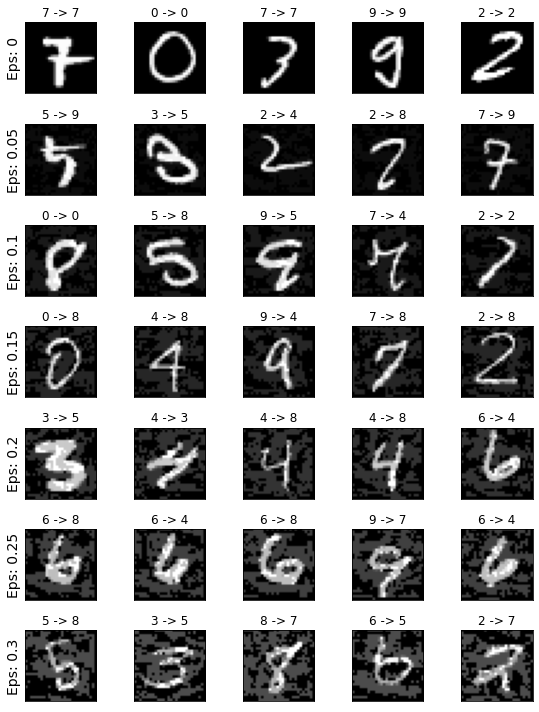

In [79]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig,adv,ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

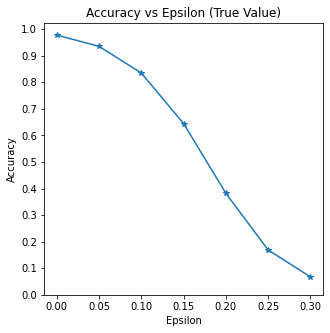

In [80]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [81]:
accuracies2 = []
examples2 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies2.append(acc)
    examples2.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9553 / 10000 = 0.9553
Epsilon: 0.1	Test Accuracy = 8539 / 10000 = 0.8539
Epsilon: 0.15	Test Accuracy = 6622 / 10000 = 0.6622
Epsilon: 0.2	Test Accuracy = 3986 / 10000 = 0.3986
Epsilon: 0.25	Test Accuracy = 1844 / 10000 = 0.1844
Epsilon: 0.3	Test Accuracy = 821 / 10000 = 0.0821


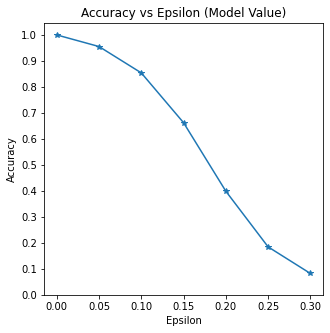

In [82]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [93]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_adv(train_dataloader, model, loss_fn, optimizer, epsilon = 0.3)
print("Done!")

Epoch 1
-------------------------------
loss: 0.101221  [    0/60000]
loss: 0.119184  [ 6400/60000]
loss: 0.020528  [12800/60000]
loss: 0.020179  [19200/60000]
loss: 0.062148  [25600/60000]
loss: 0.041821  [32000/60000]
loss: 0.051779  [38400/60000]
loss: 0.028687  [44800/60000]
loss: 0.039994  [51200/60000]
loss: 0.012085  [57600/60000]
Epoch 2
-------------------------------
loss: 0.052407  [    0/60000]
loss: 0.137751  [ 6400/60000]
loss: 0.014289  [12800/60000]
loss: 0.033122  [19200/60000]
loss: 0.003674  [25600/60000]
loss: 0.030496  [32000/60000]
loss: 0.045333  [38400/60000]
loss: 0.131147  [44800/60000]
loss: 0.025332  [51200/60000]
loss: 0.006857  [57600/60000]
Epoch 3
-------------------------------
loss: 0.042364  [    0/60000]
loss: 0.028176  [ 6400/60000]
loss: 0.121054  [12800/60000]
loss: 0.058164  [19200/60000]
loss: 0.006537  [25600/60000]
loss: 0.012321  [32000/60000]
loss: 0.036710  [38400/60000]
loss: 0.033632  [44800/60000]
loss: 0.166423  [51200/60000]
loss: 0.01

In [94]:
accuracies3 = []
examples3 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies3.append(acc)
    examples3.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9916 / 10000 = 0.9916
Epsilon: 0.05	Test Accuracy = 9651 / 10000 = 0.9651
Epsilon: 0.1	Test Accuracy = 8688 / 10000 = 0.8688
Epsilon: 0.15	Test Accuracy = 6578 / 10000 = 0.6578
Epsilon: 0.2	Test Accuracy = 3776 / 10000 = 0.3776
Epsilon: 0.25	Test Accuracy = 1665 / 10000 = 0.1665
Epsilon: 0.3	Test Accuracy = 593 / 10000 = 0.0593


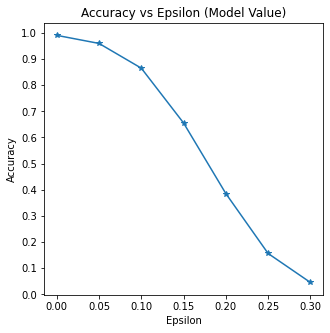

In [86]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies3, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [87]:
accuracies4 = []
examples4 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies4.append(acc)
    examples4.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9690 / 10000 = 0.969
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.15	Test Accuracy = 6642 / 10000 = 0.6642
Epsilon: 0.2	Test Accuracy = 3942 / 10000 = 0.3942
Epsilon: 0.25	Test Accuracy = 1650 / 10000 = 0.165
Epsilon: 0.3	Test Accuracy = 541 / 10000 = 0.0541


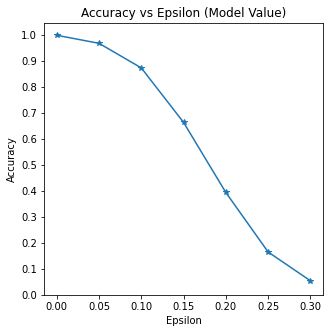

In [88]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies4, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

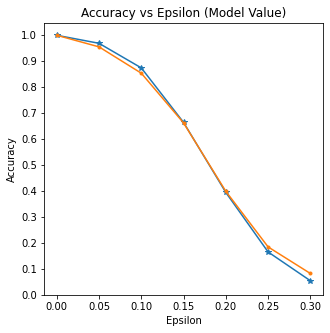

In [89]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies4, "*-")
plt.plot(epsilons, accuracies2, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

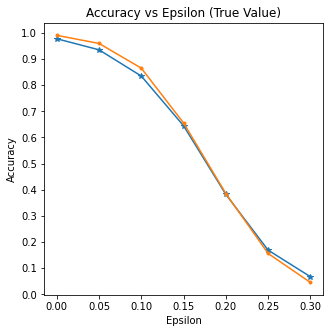

In [90]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies3, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()